# Выявление закономерностей, определяющих успешность игр.

Интернет-магазине «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Нам предоставлены данные до 2016 года. 
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».
  
**План работы:**
1. Изучить общую информацию.
2. Выполнить предобработку данных.
3. Провести исследовательский анализ.
4. Составить портрет пользователя каждого региона.
5. Проверить гипотезы. Цель исследования - выявить определяющие успешность игры закономерности.
  
**Описание данных:**
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import sqrt

#### Шаг 1. Загрузка данных

In [2]:
try:
    games = pd.read_csv('./games.csv')
except:
    games = pd.read_csv('/datasets/games.csv')

Изучаем общую информацию о полученном датафрейме.

In [3]:
def get_dataframe_info(dataframe, strings_count=10):
    display(dataframe.head(strings_count))
    dataframe.info()

In [4]:
get_dataframe_info(games)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Итоги:** в базе 16715 строк. В данных есть пропущенные значения: в названии игры, годе релиза, жанре, оценке критиков, пользователей и в рейтинге ESRB, нужно разобраться с причинами и посмотреть, можно ли их заполнить. Необходимо столбец с годом релиза, оценкой критиков и пользователей привести к корректному формату и проверить наличие дубликатов в строках.

#### Шаг 2. Предобработка данных

Приведем к нижнему регистру названия столбцов.

In [5]:
games.columns = games.columns.str.lower()

Для дальнейшей корректной работы с арифметическими операциями, переведем в целочисленный формат данные в тех столбцах, которые не могут быть дробными: дату релиза и оценку критиков; и в дробные числа оценку пользователей. Но сначала посмотрим на уникальные значения столбца `user_score`.

In [6]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Среди значений - tbd, это означает, что при выгрузке данных еще не накопилось достаточное количество оценок, чтобы можно было посчитать средний рейтинг, соответственно, предположить, какое будет в этом случае значение, нельзя. Приведем столбец с пользовательскими оценками к дробному числу, заменяя некорректные значения, в том числе tbd, на NaN.

In [7]:
games['year_of_release'] = games['year_of_release'].astype('Int64')
games['critic_score'] = games['critic_score'].astype('Int64')
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


Преобразование названий столбцов и форматов данных прошли успешно.

Обработаем пропуски. Выводим количество пропущенных значений для каждого столбца.

In [9]:
games.isna().sum().sort_values(ascending=False)

user_score         9125
critic_score       8578
rating             6766
year_of_release     269
name                  2
genre                 2
platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
dtype: int64

In [10]:
display(games.loc[games['name'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,<NA>,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,<NA>,NaN,NaN


Пропущенные значения в `name` и `genre` - это одни и те же 2 строки, в которых не указаны рейтинги, удаляем их. Посчитаем процент пропусков в столбце год релиза.

In [11]:
games.dropna(subset=['name'], inplace=True)

In [12]:
display(games.loc[games['year_of_release'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,<NA>,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,<NA>,Sports,0.01,0.00,0.00,0.00,43,NaN,E10+
16405,Freaky Flyers,GC,<NA>,Racing,0.01,0.00,0.00,0.00,69,6.5,T
16448,Inversion,PC,<NA>,Shooter,0.01,0.00,0.00,0.00,59,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.00,0.00,0.00,<NA>,NaN,NaN


Так как данные будем рассматривать в разрезе годов релиза и у некоторых строк с отсуствующим годом релиза отсутствуют оценки критиков, оценки игроков и рейтинг, то удалим эти строки из датафрейма.

In [13]:
games.dropna(subset=['year_of_release'], inplace=True)

Остальные пропуски оставляем как есть: у нас нет возможности как-то логически их заполнить.  
Причины, которые могли привести к пропускам:
* проблемы могли возникнуть на этапе загрузки и выгрузки данных
* нет данных в открытых источниках
* игра может не оцениваться рейтинговым агентством
* недостаточное количество оценок по разным причинам: не популярная игра, свежий релиз или слишком старый релиз

Посмотрим, есть ли в таблице дубликаты, так как информация могла быть получена из разных источников. Дубликаты будем искать не явные, а по столбцам: название игры, год релиза и платформа. 

In [14]:
duplicated_games = games[games.duplicated(subset=['name', 'year_of_release', 'platform'])]
duplicated_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83,5.5,E


In [15]:
display(games.loc[(games['name'] == 'Madden NFL 13') & (games['platform'] == 'PS3')])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83,5.5,E


Найден только один неявный дубликат, удалим вторую строку, так как в ней меньше информации.

In [16]:
games.drop([16230], inplace=True)

Посмотрим на уникальные значения колонки с рейтингом ESRB.

In [17]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

ESRB - организация, оценивающая игры в Северной Америке. NA значения могут означать, что игра не оценивалась в регионе или нет данных об оценке. Поставим заглушку.  
'K-A' - это устаревшее значение рейтинга 'E', произведем замену на актуалное значение рейтинга.

In [18]:
games['rating'] = games['rating'].fillna(value='Not Rated')
games.loc[games['rating'] == 'K-A', 'rating'] = 'E'

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [19]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Выведем итоговую информацию после предобработки.

In [20]:
get_dataframe_info(games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,Not Rated,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,Not Rated,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,<NA>,NaN,Not Rated,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,<NA>,NaN,Not Rated,28.31


<class 'pandas.core.frame.DataFrame'>
Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   Int64  
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 1.7+ MB


**Итоги:** приведены к нижнему регистру названия столбцов. Переведены в целочисленный формат данные в тех столбцах, которые не могут быть дробными: дата релиза и оценка критиков; и в дробные числа оценка пользователей. Удалены строки с пропусками в названиях игр и годе релиза и одна строка с неявным дубликатом. Остальные пропуски было решено оставить, так как логичной замены предложить нельзя. В столбце с рейтингом ESRB поставлена заглушка на пропуски и заменен рейтинг 'K-A' - это устаревшее значение рейтинга 'E'. Добавлен столбец с суммарными продажами каждой игры по всем регионам.

#### Шаг 3. Исследовательский анализ данных.

##### 3.1. Релизы игр по годам.

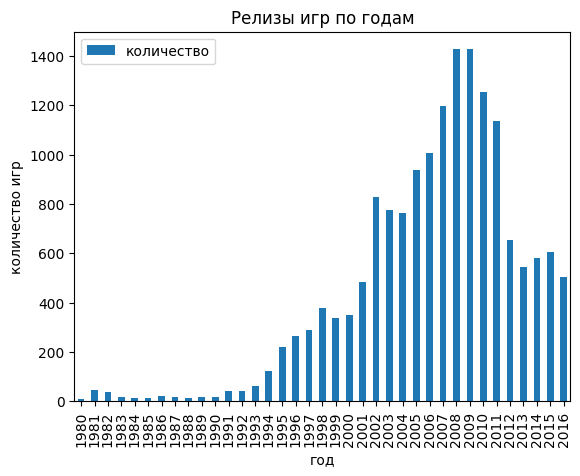

In [21]:
releases_by_year = games['year_of_release'].value_counts().sort_index()
releases_by_year.plot.bar(x='year_of_release');
plt.title('Релизы игр по годам')
plt.xlabel('год')
plt.ylabel('количество игр')
plt.legend(['количество']);

В датафрейме данные с 1980 по 2016 год. До 1995 года количество выпускаемых за год игр росло медленно. Затем начался постепенный рост. Наибольшее количество релизов было в 2009 и 2010 годах, затем количество стало снижаться. В 2016 году виден резкий рост количества релизов.  
Цель исследования - выявить определяющие успешность игры закономерности, которые позволят сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Для решения этой задачи для анализа нам достаточно данных максимум за последние 3 года.

##### 3.2. Продажи по платформам.

Рассмотрим 10 платформ с наибольшими продажами и посмотрим их распределение по годам.

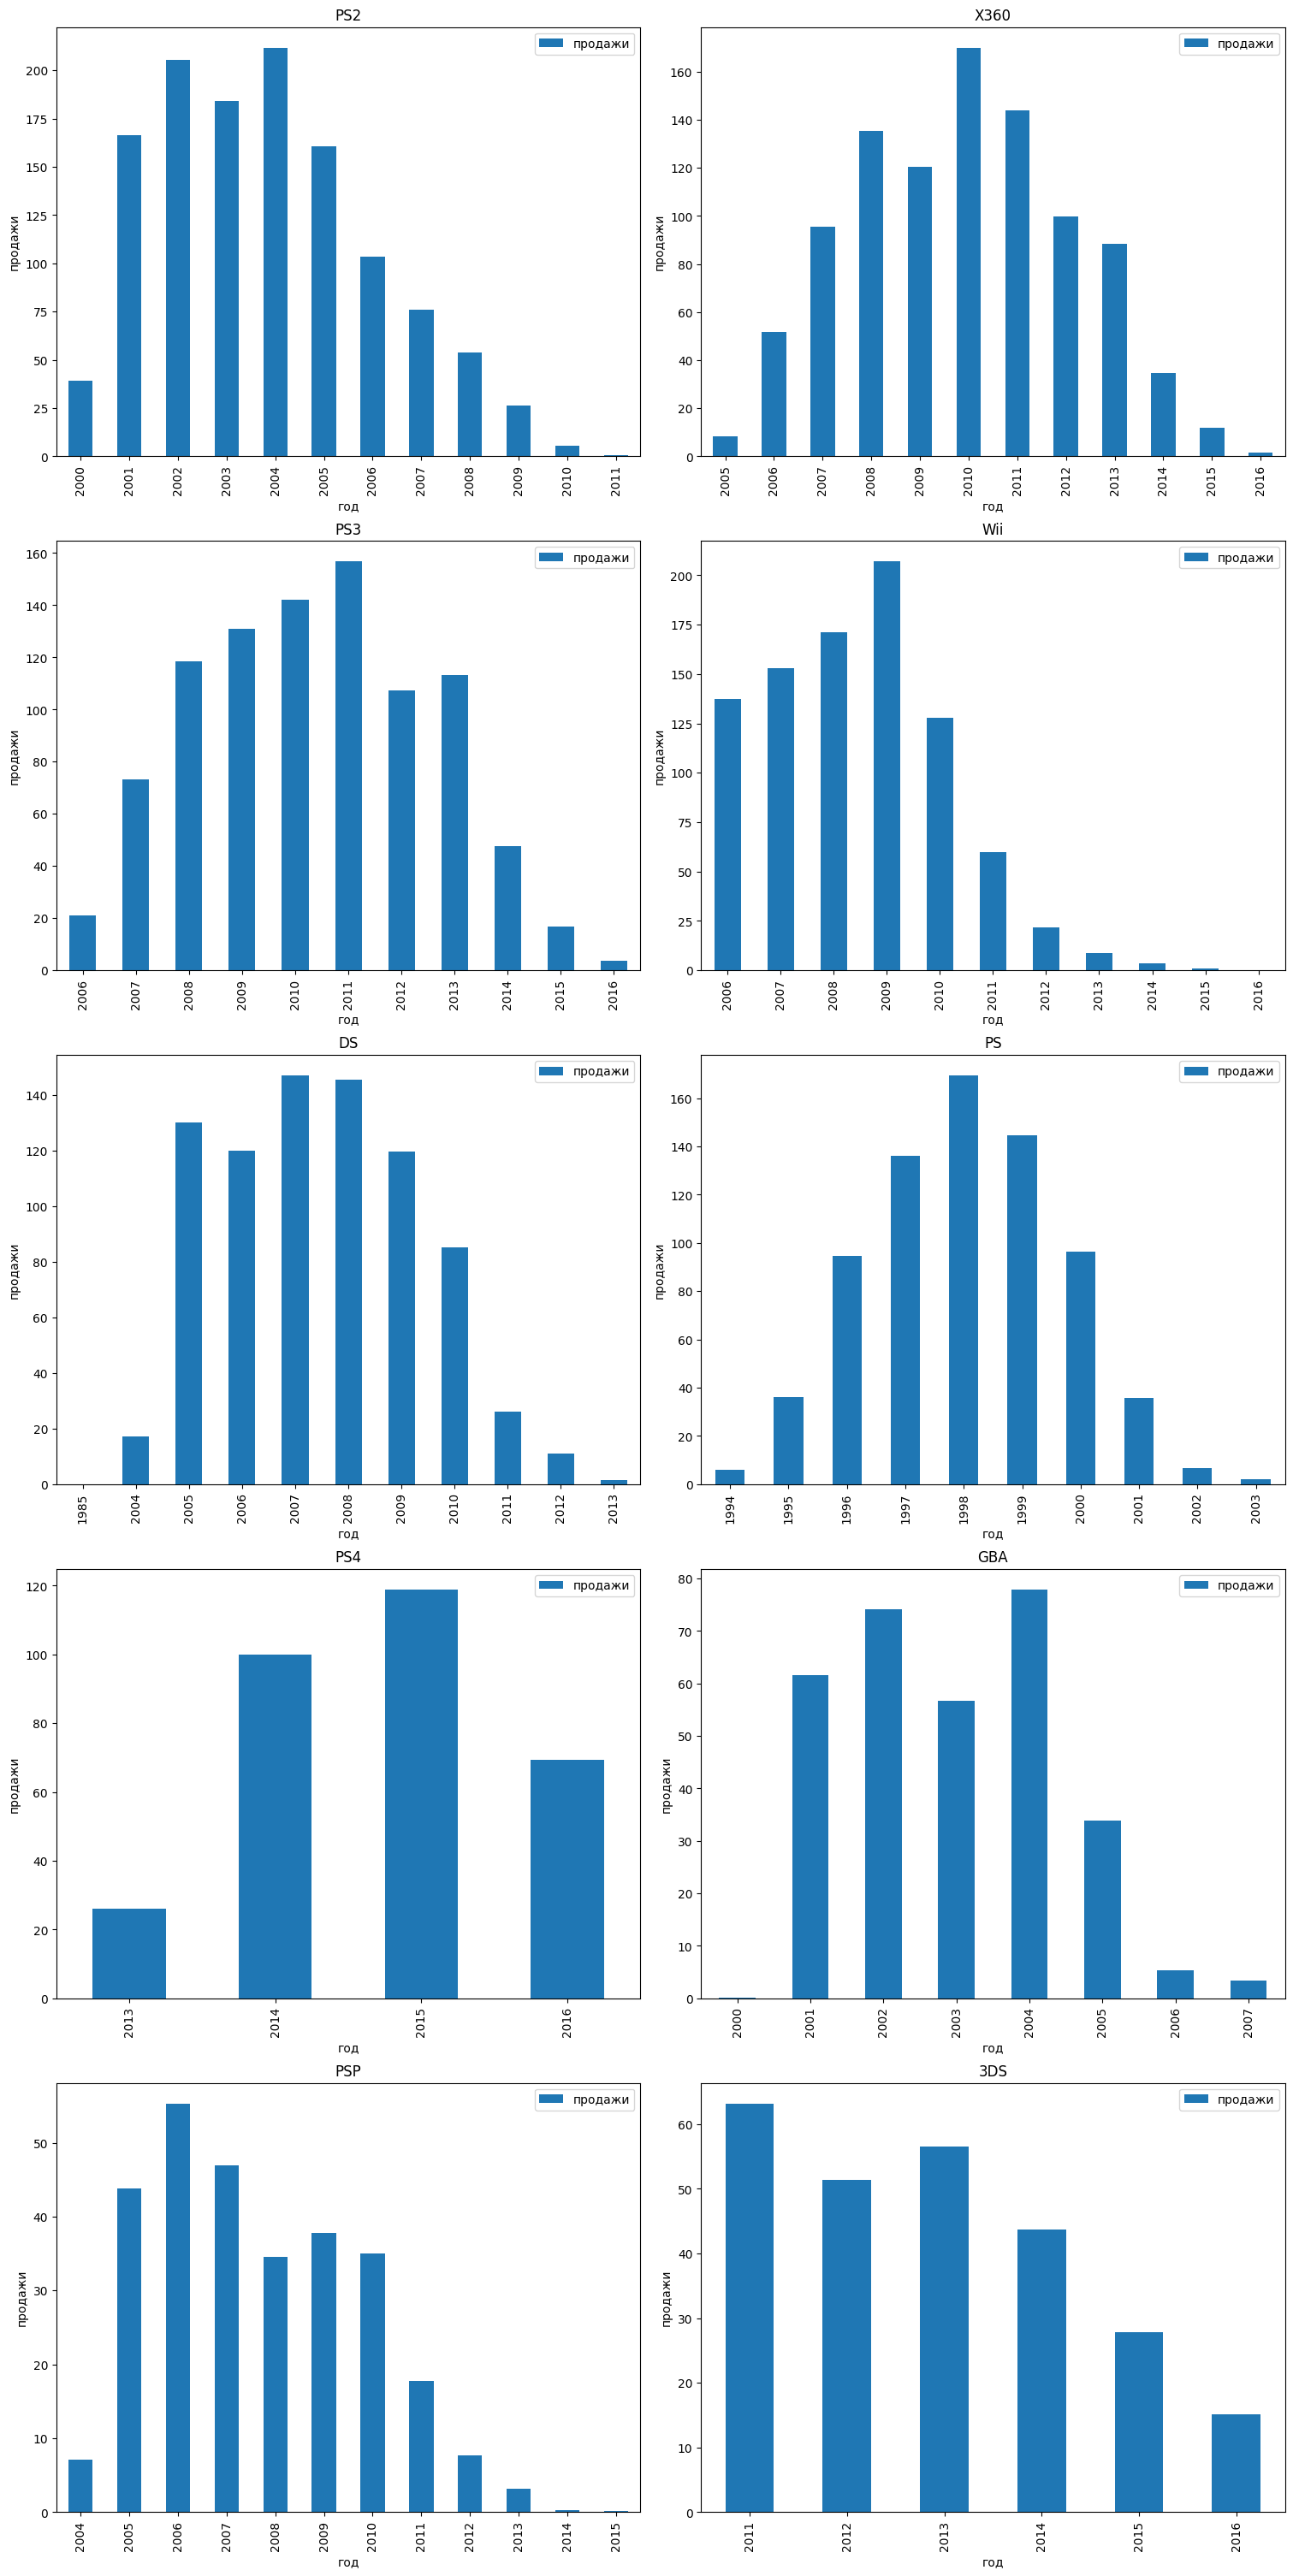

In [22]:
platforms = games.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)[:10]
yearly_sales = games.pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum').reset_index()

fig, axes = plt.subplots(5, 2, constrained_layout = True)
ax_x, ax_y = 0, 0
for item, _ in platforms.iterrows():
    ax=axes[ax_x, ax_y]
    yearly_sales.loc[yearly_sales['platform'] == item].plot.bar(ax=ax, x='year_of_release', y='total_sales', figsize=(15, 30));
    ax.set_xlabel('год')
    ax.set_ylabel('продажи')
    ax.set_title(item)
    ax.legend(['продажи'])
    if ax_y == 0:
        ax_y += 1
    else:
        ax_x += 1
        ax_y = 0 

In [23]:
temp = games.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1
time_life['life'].median()

7.0

Средний срок, за который исчезают старые и появляются новые платформы - 7 лет. Исключения на графиках - это PS4, которая появилась только в 13 году, соответственно, в 16 у нас еще нет полной статистики по продажам. И РС - с 1994 года платформа пользуется популярностью, периодически увеличивая или уменьшая годовые продажи, что вероятнее всего связано с выходами удачных релизов.

##### 3.3. Создаем датафрейм с данными за актуальный период.

In [24]:
games_current_period = games.loc[games['year_of_release'] >= 2014].reset_index(drop=True)

In [25]:
get_dataframe_info(games_current_period)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,Not Rated,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,<NA>,NaN,Not Rated,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,<NA>,NaN,Not Rated,7.98
5,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83,5.7,M,7.66
6,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85,5.0,E,7.60
7,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,3.27,1.37,2.43,0.48,<NA>,NaN,Not Rated,7.55
8,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,<NA>,NaN,Not Rated,7.39
9,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87,6.5,M,7.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   Int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    Int64  
 9   user_score       888 non-null    float64
 10  rating           1689 non-null   object 
 11  total_sales      1689 non-null   float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 161.8+ KB


Создана таблица с данными за 2014-2016 годы, в ней 1689 строк, пропуски есть в оценке критиков, оценке пользователей и рейтинге.

##### 3.4. Аналитика по платформам за актуальный период.

platform,PS4,XOne,PS3,3DS,X360,WiiU,PC,PSV,Wii,PSP
year_of_release,,,,,,,,,,
2014,100.00,54.07,47.76,43.76,34.74,22.03,13.28,11.90,3.75,0.24
2015,118.90,60.14,16.82,27.78,11.96,16.35,8.52,6.25,1.14,0.12
2016,69.25,26.15,3.60,15.14,1.52,4.60,5.25,4.25,0.18,NaN


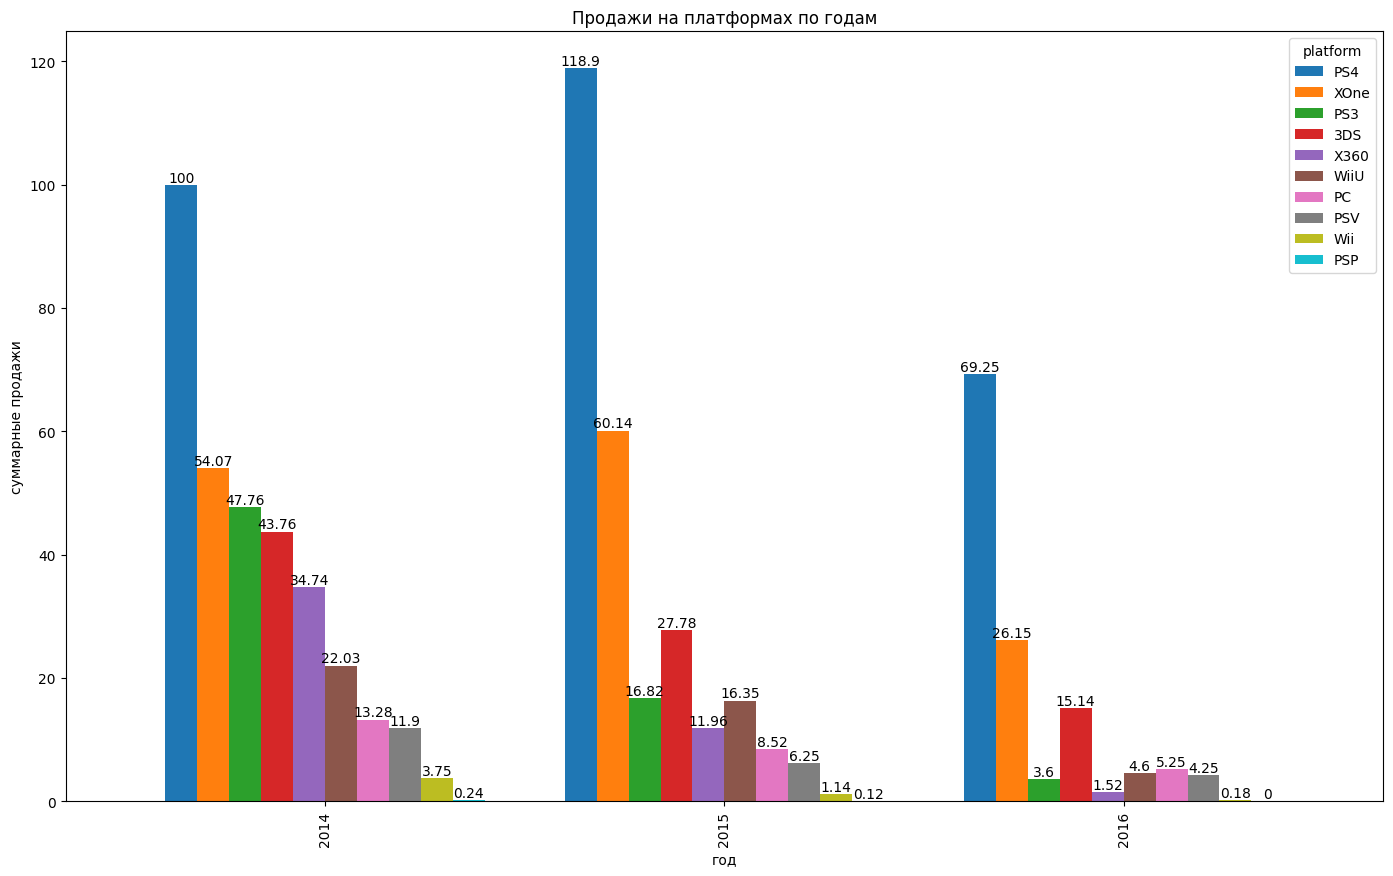

In [26]:
current_sales = games_current_period.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack().sort_values(by=2014, axis = 1, ascending=False)
display(current_sales)
ax = current_sales.plot.bar(figsize=(17,10), width=0.8)
plt.title('Продажи на платформах по годам')
plt.xlabel('год') 
plt.ylabel('суммарные продажи')
for container in ax.containers:
    ax.bar_label(container)

За последние 3 года продаются игры для 10 платформ.
* самые больше продажи у PS4, в 2015 году продажи росли по сравнению с предыдущим годом, в 2016 продажи ниже, но нужно помнить, что данные за 2016 год могут быть не полными;
* на втором месте, но с продажами почти в 2 раза ниже - XOne. Ситуация аналогична PS4 - рост в 2015 и пока падение в 2016.
* продажи по остальным платформам падают
* отдельно стоит отметить РС, ранее смотрели статистику за более длительный период и был сделан вывод, что падение продаж на данной платформе не говорит о том, что она перестала быть актуальной и что хороший релиз может обеспечить достаточно высокие продажи.  
К потенциально прибыльным платформам точно стоит отнести PS4 и XOne, так же можно рекомендовать PC.

##### 3.5. Диаграмма размаха по глобальным продажам.

Построим диаграмму размаха по глобальным продажам игр в разбивке по платформам. Возьмем данные за 2014-2016г.

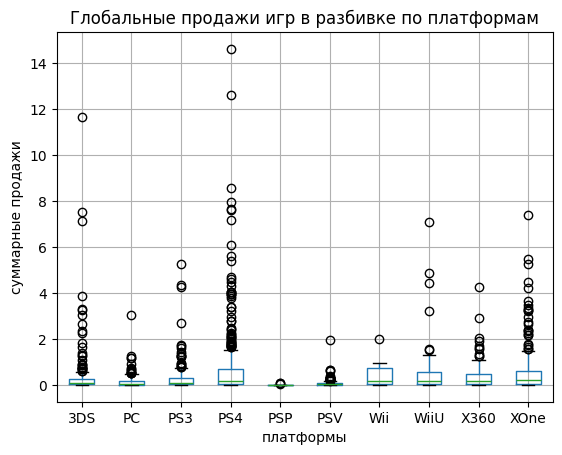

In [27]:
recent_games_sales = games_current_period.groupby(['name', 'platform'])['total_sales'].sum().unstack()
plt.xlabel('платформы') 
plt.ylabel('суммарные продажи')
plt.title('Глобальные продажи игр в разбивке по платформам')
recent_games_sales.boxplot();

Ограничим данные по продажам, чтобы посмотреть медиану и квартили.

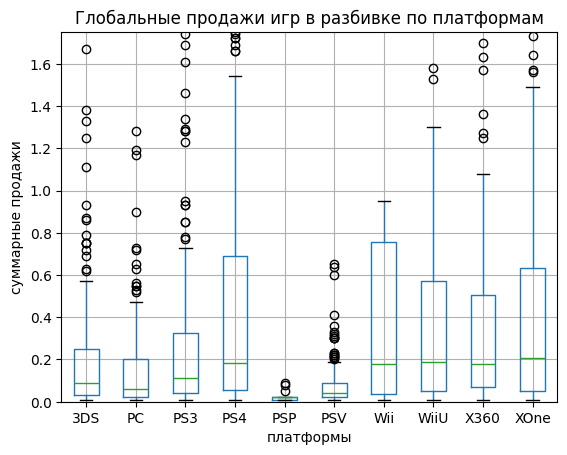

In [28]:
plt.xlabel('платформы') 
plt.ylabel('суммарные продажи')
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.ylim(0,1.75)
recent_games_sales.boxplot();

In [29]:
recent_games_sales.describe()

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
count,212.000000,151.000000,219.000000,376.000000,13.000000,295.000000,11.000000,73.000000,111.000000,228.000000
mean,0.408868,0.179139,0.311324,0.766356,0.027692,0.075932,0.460909,0.588767,0.434414,0.615614
std,1.188368,0.329359,0.633059,1.614969,0.027735,0.141591,0.625451,1.161467,0.628967,1.046513
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.030000,0.020000,0.040000,0.057500,0.010000,0.020000,0.035000,0.050000,0.070000,0.050000
50%,0.090000,0.060000,0.110000,0.185000,0.020000,0.040000,0.180000,0.190000,0.180000,0.205000
75%,0.250000,0.200000,0.325000,0.690000,0.020000,0.090000,0.755000,0.570000,0.505000,0.632500
max,11.680000,3.050000,5.270000,14.630000,0.090000,1.960000,2.010000,7.090000,4.280000,7.390000


Больше всего выбросов - очень успешных игр - на платформах PS4, XOne, 3DS. Меньше всего - WiiU. Самые успешные игры,которых продано больше 10 млн. копий это 2 игры на PS4 и одна на 3DS. Наиболее выгодными платформами являются XOne, WiiU, PS4, X360 и Wii, так как медиана и верхний квартиль этих платформ наиболее высокие.

##### 3.5. Корреляция между отзывами и продажами.

Посмотрим, как влияют на продажи внутри самой популярной платформы - PS4 отзывы пользователей и критиков. Строим диаграммы рассеяния. 

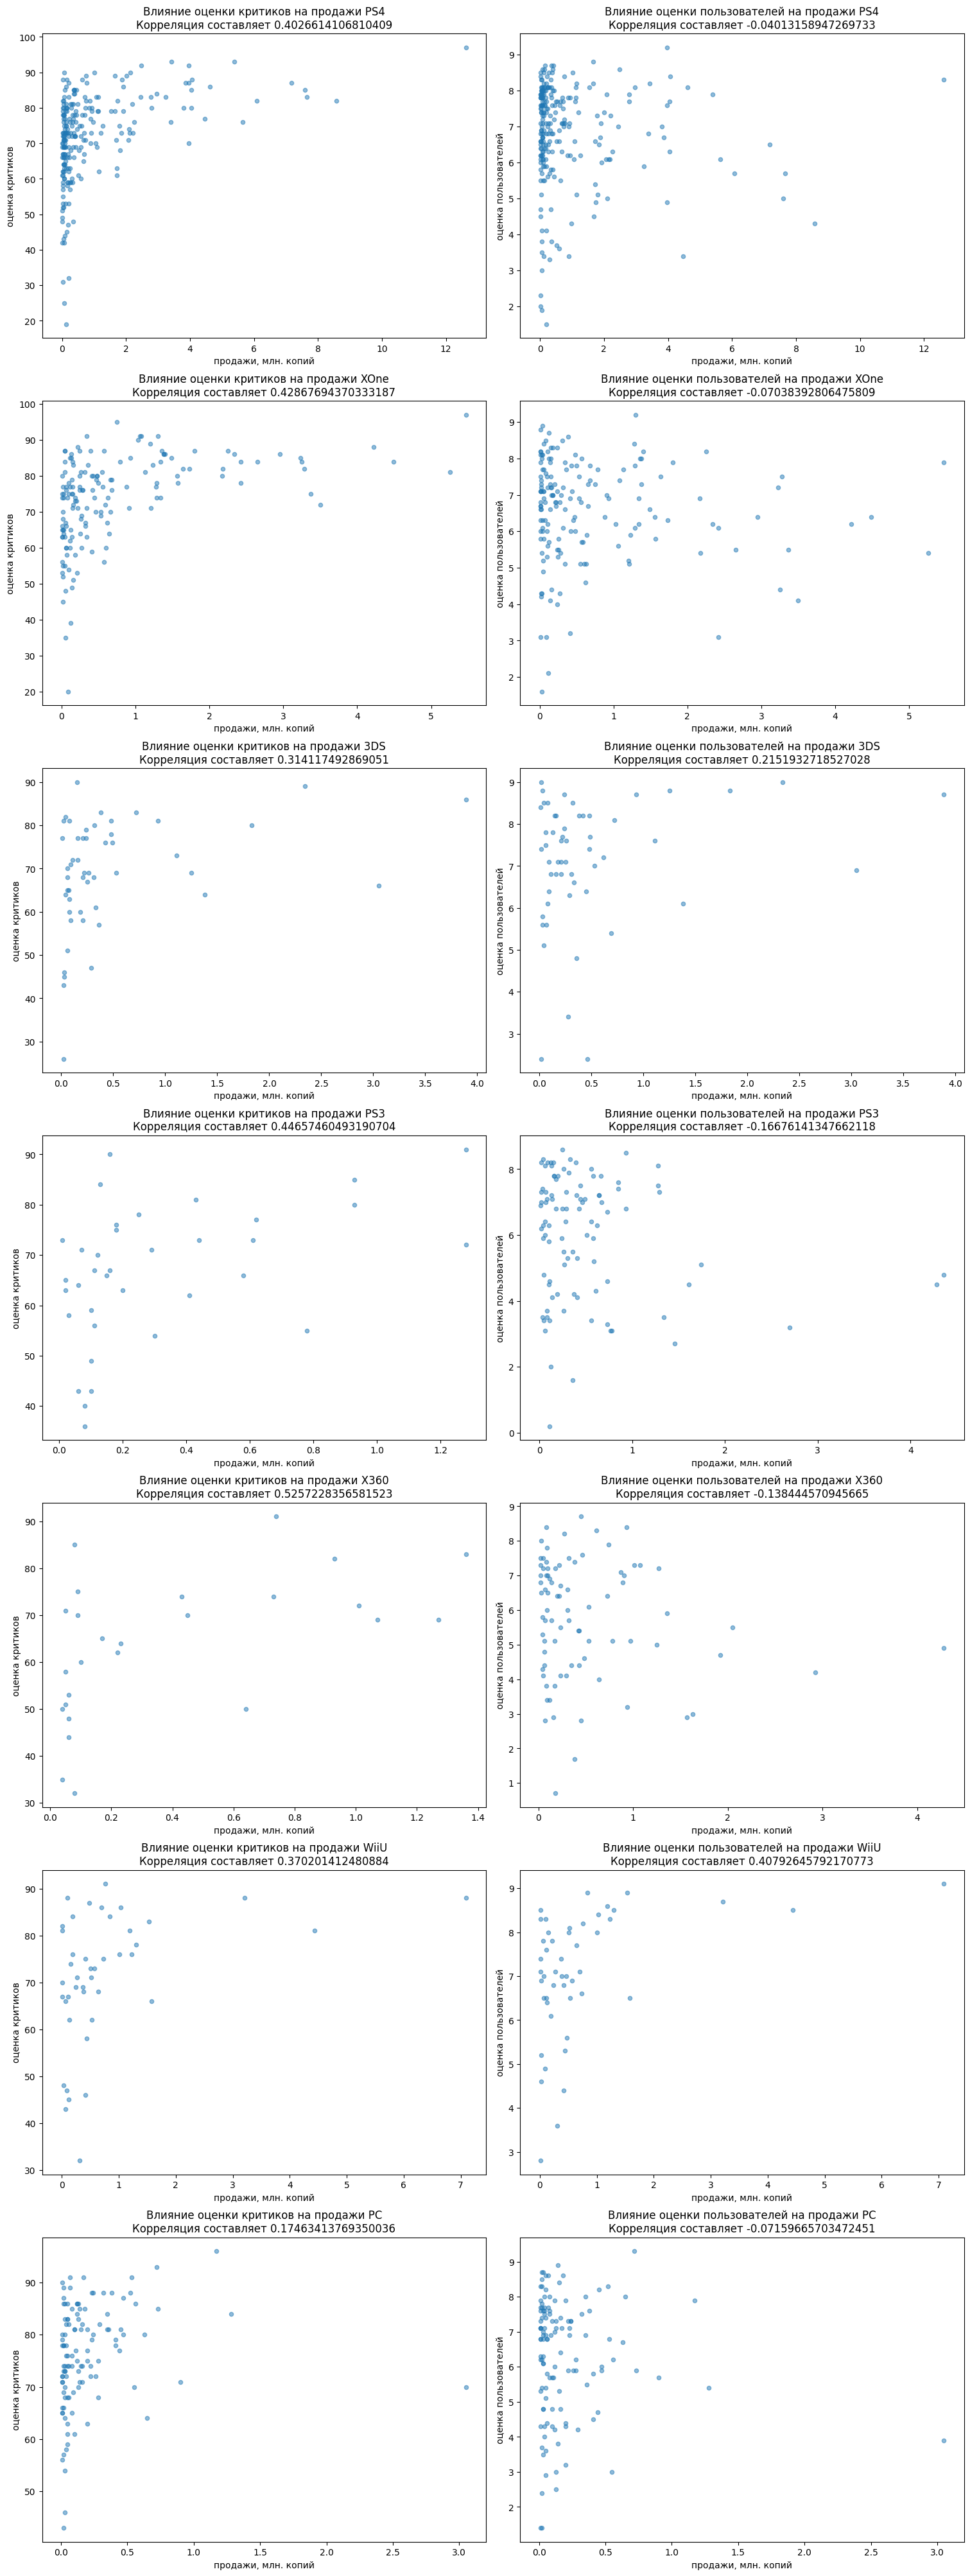

In [30]:
current_top_platforms = games_current_period.groupby(['platform'])['total_sales'].sum().sort_values(ascending=False)[:7].index

fig, axes = plt.subplots(len(current_top_platforms), 2, constrained_layout = True)
ax_i = 0

for platform in current_top_platforms:
    
    data_current_period = games_current_period.query('platform == @platform')
    critic_score_corr = data_current_period['critic_score'].dropna().astype('int64').corr(data_current_period['total_sales'])
    user_score_corr = data_current_period['user_score'].corr(data_current_period['total_sales'])

    data_current_period.plot(ax=axes[ax_i, 0], x='total_sales', y='critic_score', kind='scatter', alpha=0.5, figsize=(15, 40))
    critic_score_title = 'Влияние оценки критиков на продажи {}\nКорреляция составляет {}'.format(platform, critic_score_corr)
    
    axes[ax_i, 0].set_title(critic_score_title)
    axes[ax_i, 0].set_xlabel('продажи, млн. копий') 
    axes[ax_i, 0].set_ylabel('оценка критиков');

    data_current_period.plot(ax=axes[ax_i, 1], x='total_sales', y='user_score', kind='scatter', alpha=0.5, figsize=(15, 40))
    user_score_title = 'Влияние оценки пользователей на продажи {}\nКорреляция составляет {}'.format(platform, user_score_corr)
    
    axes[ax_i, 1].set_title(user_score_title)
    axes[ax_i, 1].set_xlabel('продажи, млн. копий') 
    axes[ax_i, 1].set_ylabel('оценка пользователей');
    
    ax_i += 1

Корреляция между продажами и оценкой критиков у популярной платформы PS4 0,4, что говорит о наличии не очень сильной связи между продажами и оценкой критиков. Такая же ситуация характерна для платформ XOne, PS3 и WiiU, корреляция у них 0,37-0,45. Самое высокое влияние оценки критиков на продажи на платформе X360 - 0,53. Продажи практически не зависят от оценки критиков на PC, где корреляция 0,17 

Корреляция между продажами и оценкой пользователей у популярной платформы PS4 -0.04, что говорит об отсутствии значимой связи между продажами игр и оценкой пользователей. Такая же ситуация характерна для остальных платформ, за исключением WiiU, где коррекляция между продажами и оценкой пользователей 0,41, то есть оценки оказывают влияние на продажи.   

##### 3.6. Распределение игр по жанрам.

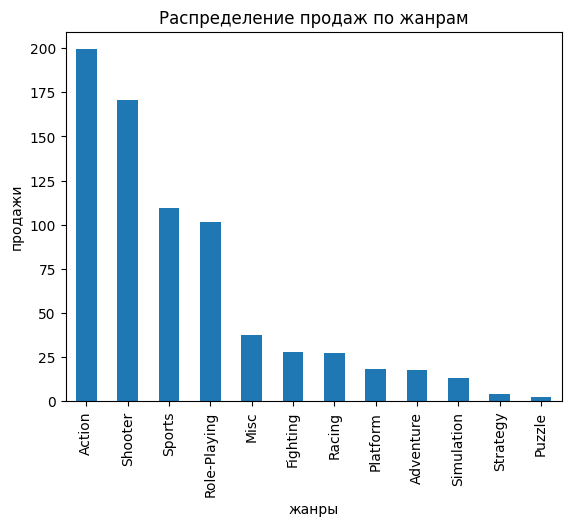

In [31]:
games_current_period.groupby('genre')['total_sales'].sum().sort_values(ascending=False).plot.bar();
plt.title('Распределение продаж по жанрам')
plt.xlabel('жанры')
plt.ylabel('продажи');

Посмотрим медианные продажи по играм в разрезе жанров, проилюстрировав их диаграммой размаха.

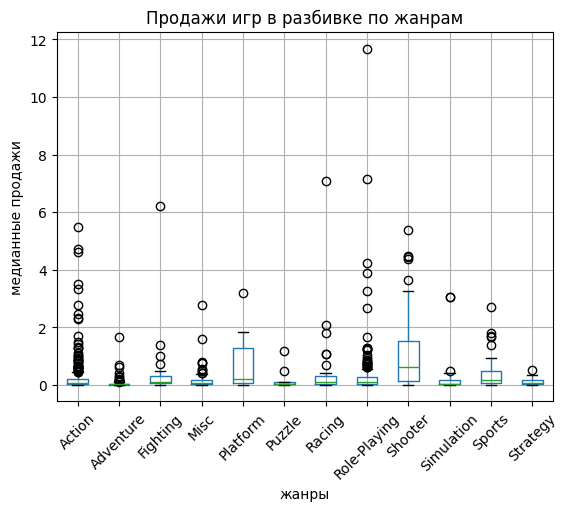

In [32]:
genre_games_sales = games_current_period.groupby(['name', 'genre'])['total_sales'].median().unstack()
plt.xlabel('жанры')
plt.ylabel('медианные продажи')
plt.title('Продажи игр в разбивке по жанрам')
ax = genre_games_sales.boxplot();
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

Ограничим данные по продажам, чтобы посмотреть медиану и квартиль.

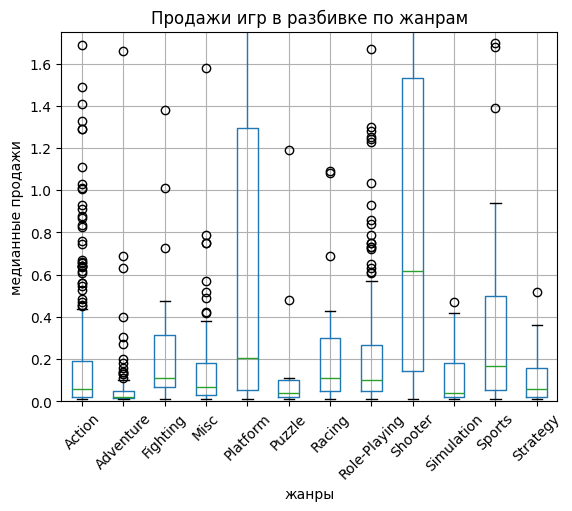

In [33]:
plt.xlabel('жанры') 
plt.xticks(rotation=90)
plt.ylabel('медианные продажи')
plt.title('Продажи игр в разбивке по жанрам')
plt.ylim(0,1.75)
ax = genre_games_sales.boxplot();
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [34]:
genre_games_sales.describe()

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
count,338.000000,127.000000,34.000000,73.000000,22.000000,10.000000,28.000000,151.000000,51.000000,35.000000,55.000000,32.000000
mean,0.250577,0.066339,0.398235,0.203219,0.644773,0.200000,0.583750,0.441921,1.148137,0.281571,0.396909,0.109219
std,0.626951,0.172001,1.068584,0.393734,0.845943,0.375389,1.382492,1.242013,1.400264,0.704493,0.539450,0.124221
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.020000,0.015000,0.070000,0.030000,0.052500,0.022500,0.048750,0.050000,0.145000,0.020000,0.052500,0.020000
50%,0.060000,0.020000,0.110000,0.070000,0.205000,0.040000,0.110000,0.100000,0.620000,0.040000,0.170000,0.060000
75%,0.190000,0.050000,0.312500,0.180000,1.293750,0.100000,0.302500,0.265000,1.530000,0.180000,0.500000,0.157500
max,5.470000,1.660000,6.210000,2.760000,3.210000,1.190000,7.090000,11.680000,5.390000,3.050000,2.700000,0.520000


Самый прибыльный жанр - Shooter, медианные продажи которого сильно превышают остальные жанры. Высокие продажи у Platform и Sports. В жанре Action, который лидирует по суммарным продажам, низкое медианное значение продаж, что говорит о том, что большинство игр прожаются небольшим объемом, но в этом жанре много выбросов - очень успешных игры, которые зарабатывают значительно больше среднего.

**Итоги:** были проанализированы игры, вышедшие с 1980 по 2016 год. До 1995 года количество выпускаемых за год игр росло медленно. Затем начался постепенный рост. Наибольшее количество релизов было в 2009 и 2010 годах, затем количество стало снижаться. В 2016 году виден резкий рост количества релизов. Средний срок, за который исчезают старые и появляются новые платформы - 7 лет. Исключение - РС, с 1994 года платформа пользуется популярностью, периодически увеличивая или уменьшая годовые продажи, что вероятнее всего связано с выходами удачных релизов.  
Для достижения цели исследования - выявить определяющие успешность игры закономерности, которые позволят сделать ставку на потенциально популярный продукт и спланировать рекламные кампании, было принято решение оставить данные только за последние 3 года. За этот период самые успешные платформы - PS4 и XOne. Больше всего очень успешных игр - на платформах PS4, XOne, 3DS. Меньше всего - WiiU. Самые успешные игры, которых продано больше 10 млн. копий это 2 игры на PS4 и одна на 3DS. Наиболее выгодными платформами являются XOne, WiiU, PS4, X360 и Wii, так как медиана и верхний квартиль этих платформ наиболее высокие.  
Оценка критиков незначительно влияет на продажи больше всего на платформе - X360, меньше - на РС. Оценка пользователей влияния на продажи не оказывает, исключение - WiiU, где есть незначительное влияние оценки пользователей на продажи.  
Самый прибыльный жанр - Shooter, медианные продажи которого сильно превышают остальные жанры. Высокие медианные продажи у Platform и Sports.

#### Шаг 4. Портрет пользователя каждого региона.

##### 4.1. Самые популярные платформы по регионам.

In [35]:
#функция для подсчета продаж по регионам в различных разрезах
def region_sales(sales, region, param):
    sales = sales.groupby(param)[region].sum().sort_values(ascending=False)
    top_sales = sales[:5].copy()
    top_sales['others'] = sales[5:].sum()
    return top_sales

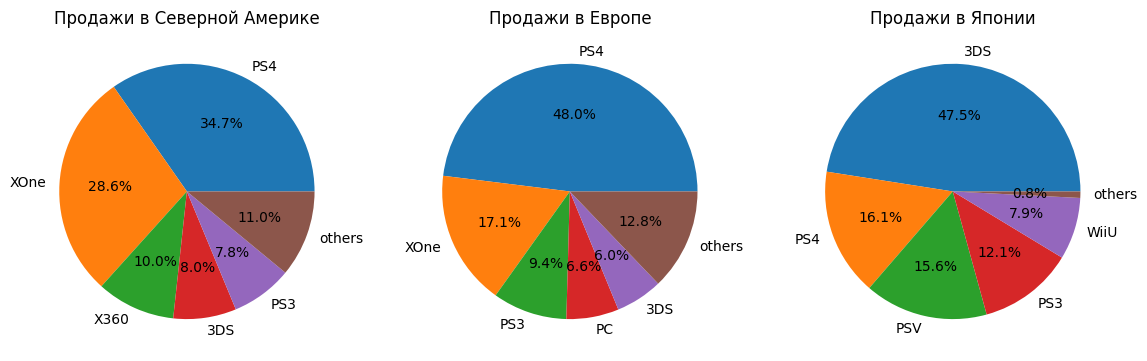

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
                               
na_sale = region_sales(games_current_period, 'na_sales', 'platform')
ax1.pie(na_sale, labels=na_sale.index, autopct='%1.1f%%')
ax1.set_title('Продажи в Северной Америке')

eu_sale = region_sales(games_current_period, 'eu_sales', 'platform')
ax2.pie(eu_sale, labels=eu_sale.index, autopct='%1.1f%%')
ax2.set_title('Продажи в Европе')

jp_sale = region_sales(games_current_period, 'jp_sales', 'platform')
ax3.pie(jp_sale, labels=jp_sale.index, autopct='%1.1f%%')
ax3.set_title('Продажи в Японии')

plt.show()

В Северной Америке самая популярная платформа - PS4 (34,7%), на втором месте - XOne(28,6%). Консоли Sony (PS4 и PS3) занимают 42,5% доли рынка, консоли от Microsoft (XOne и X360) - 38,6%. В Европе у Sony доля рынка еще больше - 57,4%, так же можно отметить, что Европа - единственный рынок с существенной долей продаж игр для PC - 6,6%.  
Рынок Японии сильно отличается от остальных. Более 99% рынка занимают японские консоли от Sony и Nintendo.Там самой популярной является японская портативная консоль - 3DS (46,5%). Если посмотреть на весь топ-5, видно, что в Японии предпочитают портативные консоли: 3DS и PSV, их суммарная доля на этом рынке - 63,1%

##### 4.2. Самые популярные жанры по регионам.

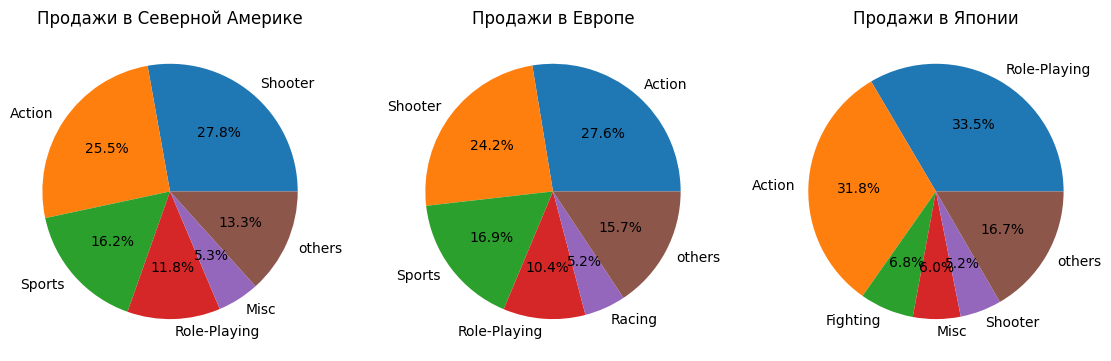

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
                               
na_sale = region_sales(games_current_period, 'na_sales', 'genre')
ax1.pie(na_sale, labels=na_sale.index, autopct='%1.1f%%')
ax1.set_title('Продажи в Северной Америке')

eu_sale = region_sales(games_current_period, 'eu_sales', 'genre')
ax2.pie(eu_sale, labels=eu_sale.index, autopct='%1.1f%%')
ax2.set_title('Продажи в Европе')

jp_sale = region_sales(games_current_period, 'jp_sales', 'genre')
ax3.pie(jp_sale, labels=jp_sale.index, autopct='%1.1f%%')
ax3.set_title('Продажи в Японии')

plt.show()

В Европе и Северной Америке ситуация по жанрам похожа: самые популярные - Action и Shooter с примерно одинаковой долей. В Северной Америке больше играют в Shooter, в Европе - в Action. На третьем месте - Sports, на четвертом - Role-Playing. В Японии по-другому: Role-Playing с долей 33,5% на первом месте, на втором немного отстает Action с долей 31,8%. А Shooter продаются плохо, доля их в Японии только 5,2%.

##### 4.3. Влияние рейтинга ESRB на продажи в отдельном регионе.

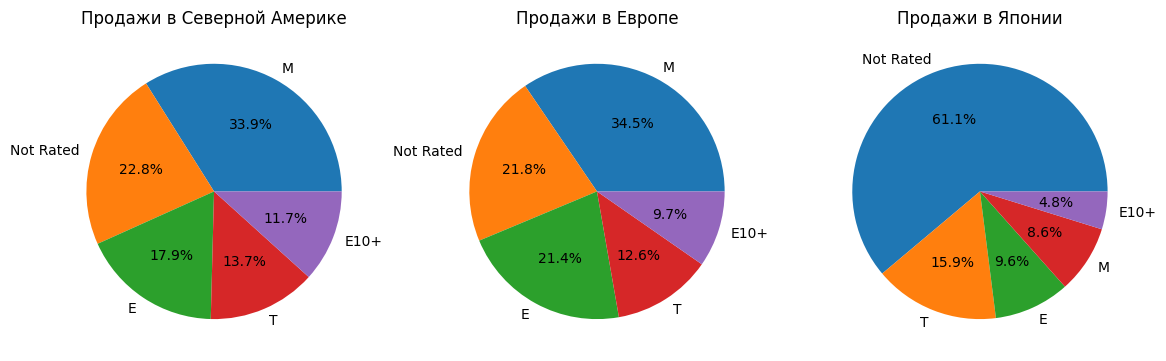

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
                               
na_sale = games_current_period.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
ax1.pie(na_sale, labels=na_sale.index, autopct='%1.1f%%')
ax1.set_title('Продажи в Северной Америке')

eu_sale = games_current_period.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
ax2.pie(eu_sale, labels=eu_sale.index, autopct='%1.1f%%')
ax2.set_title('Продажи в Европе')

jp_sale = games_current_period.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)
ax3.pie(jp_sale, labels=jp_sale.index, autopct='%1.1f%%')
ax3.set_title('Продажи в Японии')

plt.show()

Распределение игр по рейтингу в Северной Америке и Европе одинаковое. Самая большая доля - М (для взрослых), на втором месте Not Rated, на третьем - E, самая маленькая доля - Е10+(от 10 лет). В большинстве случаев игры, которые выходят в Северной Америке и Европе аналогичны и выходят одновременно, соответственно высокая доля Not Rated говорит о том, что отсутствуют данные или рейтинг еще не получен. Такое распределение хорошо соотносится с популярностью жанров: в Америке и Европе популярны Action и Shooter, игры этих жанров часто имею не подходящее для детей содержание и им присваивается рейтинг М.  
В Японии ситуация другая: 61% продаж - это игры с рейтингом Not Rated, затем T, E, M и Е10+. Здесь можно предположить высокую долю игр, которые выпускаются только для японского рынка и, соответственно, не получают рейтинг ESRB.

#### Шаг 5. Проверка гипотез.

##### 5.1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Проверяем гипотезу.  
Нулевая гипотеза: средние пользовательские рейтинги платформ XOne и PC одинаковые.  
Альтернативная гипотеза: средние пользовательские рейтинги платформ XOne и PC разные.  
Здесь подходит тест st.ttest_ind и проверяется двусторонняя гипотеза.
Возьмем уровень статистической значимости 5%.

In [39]:
alpha = 0.05

results = st.ttest_ind(games_current_period.loc[games_current_period['platform'] == 'XOne']['user_score'].dropna(), \
                       games_current_period.loc[games_current_period['platform'] == 'PC']['user_score'].dropna())
print('p-value:', results.pvalue)
print('Cредний пользовательский рейтинг платформы XOne:', round(games_current_period.loc[games_current_period['platform'] == 'XOne']['user_score'].mean(), 2))
print('Cредний пользовательский рейтинг платформы PC:', round(games_current_period.loc[games_current_period['platform'] == 'PC']['user_score'].mean(), 2))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.10450507919348415
Cредний пользовательский рейтинг платформы XOne: 6.59
Cредний пользовательский рейтинг платформы PC: 6.3
Нет оснований отвергнуть нулевую гипотезу


Мы не можем отвергнуть нулевую гипотезу, это значит, что с большой вероятностью средние пользовательские рейтинги платформ XOne и PC одинаковые.

##### 5.2. Средние пользовательские рейтинги жанров Action и Sports разные.

Проверяем гипотезу.  
Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковые.  
Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.  
Здесь подходит тест st.ttest_ind и проверяется двусторонняя гипотеза.
Возьмем уровень статистической значимости 5%.

In [40]:
alpha = 0.05

results = st.ttest_ind(games_current_period.loc[games_current_period['genre'] == 'Action']['user_score'].dropna(), \
                       games_current_period.loc[games_current_period['genre'] == 'Sports']['user_score'].dropna())
print('p-value:', '{0:.20f}'.format(results.pvalue))
print('Средний пользовательский рейтинг жанра Action:', round(games_current_period.loc[games_current_period['genre'] == 'Action']['user_score'].mean(), 2))
print('Средний пользовательский рейтинг жанра Sports:', round(games_current_period.loc[games_current_period['genre'] == 'Sports']['user_score'].mean(), 2))
      
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.00000000000000000029
Средний пользовательский рейтинг жанра Action: 6.76
Средний пользовательский рейтинг жанра Sports: 5.23
Отвергаем нулевую гипотезу


Полученное значение p-value значительно меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что средние пользовательские рейтинги жанров Action и Sports разные.

#### Общий вывод.

В рамках проекта был проведен анализ исторических данных из открытых источников о продажах игр, оценке пользователей и экспертов, жанрах и платформах (например, Xbox или PlayStation). Нужно было выявить определяющие успешность игры закономерности. Что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании для интернет-магазина "Стримчик", который продает по всему миру компьютерные игры.  
В ходе исследования были расмотрены данные: название игры, платформа, год выпуска, жанр игры, продажи в Северной Америке, Европе, Японии и других странах (миллионы проданных копий), оценка критиков (максимум 100), оценка пользователей (максимум 10), рейтинг от организации ESRB.  
В ходе предобработки данных приведены к нижнему регистру названия столбцов. Переведены в целочисленный формат данные в тех столбцах, которые не могут быть дробными: дата релиза и оценка критиков; и в дробные числа оценка пользователей. Удалены строки с пропусками в названиях игр и годе релиза и одна строка с неявным дубликатом. Остальные пропуски было решено оставить, так как логичной замены предложить нельзя. В столбце с рейтингом ESRB поставлена заглушка на пропуски и заменен рейтинг 'K-A' - это устаревшее значение рейтинга 'E'.
Причины, которые могли привести к пропускам:
* проблемы могли возникнуть на этапе загрузки и выгрузки данных
* нет данных в открытых источниках
* игра может не оцениваться рейтинговым агентством
* недостаточное количество оценок по разным причинам: не популярная игра, свежий релиз или слишком старый релиз  
  
Исследовательский анализ за период с 1980 по 2016 год показал, что средний срок, за который исчезают стыре и появляются новые платформы - 7 лет. Исключения на графиках - это PS4, которая появилась только в 13 году, соответственно, в 16 у нас еще нет полной статистики по продажам. И РС - с 1994 года платформа пользуется популярностью, периодически увеличивая или уменьшая годовые продажи, что вероятнее всего связано с выходами удачных релизов.  
Для целей исследования было решено в дальнейшем работать только с данными за последние 3 года.
За последние 3 года продаются игры для 10 платформ. Общие выводы по этому периоду: 
* самые больше продажи у PS4, в 2015 году продажи росли по сравнению с предыдущим годом, в 2016 продажи ниже, но нужно помнить, что данные за 2016 год могут быть не полными;
* на втором месте, но с продажами почти в 2 раза ниже - XOne. Ситуация аналогична PS4 - рост в 2015 и пока падение в 2016;
* продажи по остальным платформам падают;
* отдельно стоит отметить РС, ранее смотрели статистику за более длительный период и был сделан вывод, что падение продаж на данной платформе не говорит о том, что она перестала быть актуальной и что хороший релиз может обеспечить достаточно высокие продажи;
* больше всего очень успешных игр - на платформах PS4, XOne, 3DS. Меньше всего - WiiU. Самые успешные игры, которых продано больше 10 млн. копий это 2 игры на PS4 и одна на 3DS. Наиболее выгодными платформами являются XOne, WiiU, PS4, X360 и Wii, так как медиана и верхний квартиль этих платформ наиболее высокие.
* оценка критиков незначительно влияет на продажи.  Самое высокое влияние оценки критиков на продажи на платформе X360 - 0,53. Продажи практически не зависят от оценки критиков на PC, где корреляция 0,17 
* оценка пользователей влияния на продажи не оказывает, за исключением WiiU, где корреляция между продажами и оценкой пользователей 0,41, то есть оценки оказывают незначительное влияние на продажи.  
* cамый прибыльный жанр - Shooter, медианные продажи которого сильно превышают остальные жанры. Высокие медианные продажи у Platform и Sports.  
  
Портрет пользователя по регионам.  
В Северной Америке самая популярная платформа - PS4 (34,7%), на втором месте - XOne(28,6%). Консоли Sony (PS4 и PS3) занимают 42,5% доли рынка, консоли от Microsoft (XOne и X360) - 38,6%. В Европе у Sony доля рынка еще больше - 57,4%, так же можно отметить, что Европа - единственный рынок с существенной долей продаж игр для PC - 6,6%.  
Рынок Японии сильно отличается от остальных. Более 99% рынка занимают японские консоли от Sony и Nintendo.Там самой популярной является японская портативная консоль - 3DS (46,5%). Если посмотреть на весь топ-5, видно, что в Японии предпочитают портативные консоли: 3DS и PSV, их суммарная доля на этом рынке - 63,1%.   
В Европе и Северной Америке ситуация по жанрам похожа: самые популярные - Action и Shooter с примерно одинаковой долей. В Северной Америке больше играют в Shooter, в Европе - в Action. На третьем месте - Sports, на четвертом - Role-Playing. В Японии по-другому: Role-Playing с долей 33,5% на первом месте, на втором немного отстает Action с долей 31,8%. А Shooter продаются плохо, доля их в Японии только 5,2%.  
Распределение игр по рейтингу в Северной Америке и Европе одинаковое. Самая большая доля - М (для взрослых), на втором месте Not Rated, на третьем - E, самая маленькая доля - Е10+(от 10 лет). В большинстве случаев игры, которые выходят в Северной Америке и Европе аналогичны и выходят одновременно, соответственно высокая доля Not Rated говорит о том, что отсутствуют данные или рейтинг еще не получен. Такое распределение хорошо соотносится с популярностью жанров: в Америке и Европе популярны Action и Shooter, игры этих жанров часто имею не подходящее для детей содержание и им присваивается рейтинг М. В Японии ситуация другая: 61% продаж - это игры с рейтингом Not Rated, затем T, E, M и Е10+. Здесь можно предположить высокую долю игр, которые выпускаются только для японского рынка и, соответственно, не получают рейтинг ESRB.
  
Можно дать следующие **рекомендации** для проведения рекламных кампаний:
* при планировании рекламных кампаний необходимо обязательно учитывать регион, Европу и Северную Америку в целом можно объединять, Японию планировать отдельно
* в Америке и Европе стоит отдавать приоритет играм для PS4 и XOne, в Японии - 3DS, PS4 и PSV
* в Америке и Европе жанры, корторые привлекут внимание - Action и Shooter, в Японии - Role-Playing
* рейтинг ESRB соотносится с популярностью жанров в Европе и Северной Америке, можно его не учитывать при планировании. В Японии в большинстве игр рейтинг не указан, можно предположить, что больше всего пользуются популярностью игры, выпущенные только для японского рынка
* оценки критиков стоит учитывать при проведении рекламных кампний для большинства платформ (кроме PC), оценку пользователей - нет, за исключением WiiU, где небольшая зависимость есть.